In [33]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx
import json
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [34]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType
from helperfunctions.randomcircuit import random_quantum_circuit_large_with_params

from rustworkx.visualization import graphviz_draw

In [35]:
# Change these values for different number of input(q), ancilla(a) and gates(g)
q = 4
a = 7 
g = 40
comp_circuit, q, a, g = random_quantum_circuit_large_with_params(num_q=q,num_a=a,num_g=g,
                                                                 add_random_h=True)
# comp_circuit.draw('latex')
ancillas_list = [breakdown_qubit(q)['label'] for q in comp_circuit.qubits][-a:]
# ancillas = breakdown_qubit
comp_graph = get_computation_graph(comp_circuit, ancillas_list)

Adding Nodes for Circuit: 100%|██████████| 76/76 [00:00<00:00, 170737.60it/s]


In [36]:
largest_ancilla = exhaustive_uncomputation_adding(comp_graph, ancillas_list)
exhaustive_cg, cycle = add_uncomputation(comp_graph, largest_ancilla)
exhaustive_circuit = get_uncomp_circuit(exhaustive_cg)

Checking Out Exhaustive Uncomp for All Ancillas: 128it [00:00, 450.06it/s]
Building uncomp circuit from circuit graph: 100%|██████████| 91/91 [00:00<00:00, 60671.06it/s]


In [37]:
greedy_full_cg = greedy_uncomputation_full(comp_graph, ancillas_list)
greedy_full_circuit = get_uncomp_circuit(greedy_full_cg)

Building uncomp circuit from circuit graph: 100%|██████████| 91/91 [00:00<00:00, 58112.31it/s]


In [38]:
greedy_part_cg = greedy_uncomputation_partial(comp_graph, ancillas_list)
greedy_part_circuit = get_uncomp_circuit(greedy_part_cg)

Building uncomp circuit from circuit graph: 100%|██████████| 91/91 [00:00<00:00, 61383.35it/s]


In [39]:
desired_sv = zero_ancillas_in_statevector(Statevector(comp_circuit), a)


In [40]:
no_uncomp = Statevector(comp_circuit).probabilities_dict(range(q))
desired = Statevector(desired_sv).probabilities_dict(range(q))
exhaustive = Statevector(exhaustive_circuit).probabilities_dict(range(q))
greedy_full = Statevector(greedy_full_circuit).probabilities_dict(range(q))
greedy_part = Statevector(greedy_part_circuit).probabilities_dict(range(q))

In [41]:
print(len(desired_sv))
print(len(desired))

2048
16


In [42]:
print(desired)

{np.str_('0000'): np.float64(0.003906250000012644), np.str_('0001'): np.float64(1.279999999999996e-14), np.str_('0010'): np.float64(0.003906250000012644), np.str_('0011'): np.float64(1.279999999999996e-14), np.str_('0100'): np.float64(1.279999999999996e-14), np.str_('0101'): np.float64(0.14062500000001327), np.str_('0110'): np.float64(1.279999999999996e-14), np.str_('0111'): np.float64(1.279999999999996e-14), np.str_('1000'): np.float64(0.015625000000012712), np.str_('1001'): np.float64(1.279999999999996e-14), np.str_('1010'): np.float64(1.279999999999996e-14), np.str_('1011'): np.float64(1.279999999999996e-14), np.str_('1100'): np.float64(1.279999999999996e-14), np.str_('1101'): np.float64(1.279999999999996e-14), np.str_('1110'): np.float64(1.279999999999996e-14), np.str_('1111'): np.float64(0.06250000000001199)}


In [43]:
plot_x = no_uncomp.keys()
plt_dict = {'no_uncomp':[], 'desired':[], 'exhaustive':[], 'greedy_full':[], 'greedy_part':[]}
for i in plot_x:
    plt_dict['no_uncomp'].append(no_uncomp[i])
    plt_dict['desired'].append(desired[i])
    plt_dict['exhaustive'].append(exhaustive[i])
    plt_dict['greedy_full'].append(greedy_full[i])
    plt_dict['greedy_part'].append(greedy_part[i])

In [44]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

In [45]:
import pandas as pd

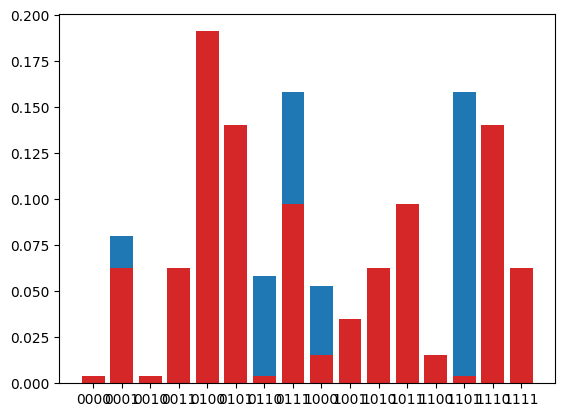

In [46]:
plt.bar(x=plot_x, height=plt_dict['no_uncomp'])
plt.bar(x=plot_x, height=plt_dict['exhaustive'])
plt.bar(x=plot_x, height=plt_dict['greedy_full'])
plt.bar(x=plot_x, height=plt_dict['greedy_part'])

plt.show()

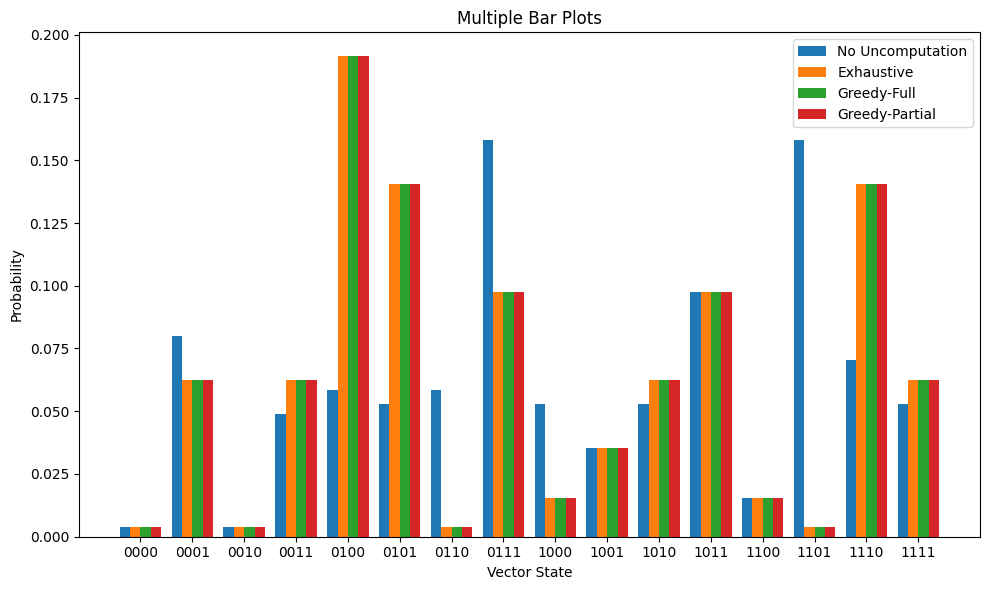

In [47]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects2 = ax.bar(x - 0.5 * width, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 0.5 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 1.5 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

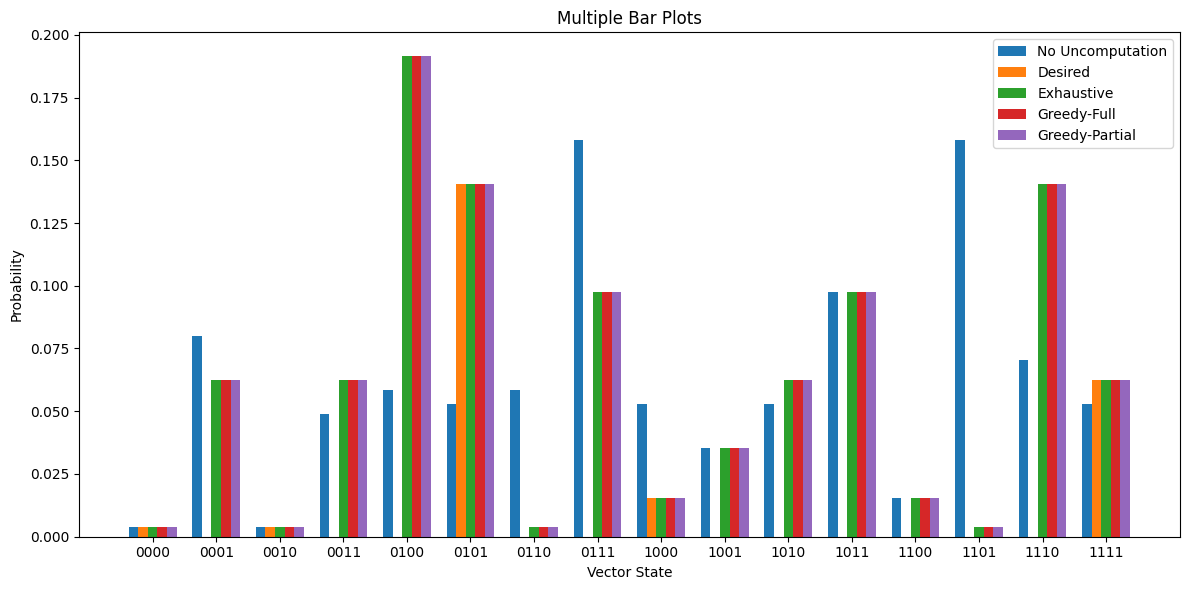

In [48]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects1 = ax.bar(x - 1 * width, plt_dict['desired'], width, label='Desired')
rects2 = ax.bar(x, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 1 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 2 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()